In [41]:
import torch
from qadence import feature_map, hea, chain, add
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

In [42]:
def dfdx_equation(fx: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return -8 * fx * (0.1 + torch.tan(8 * x))

In [43]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [44]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(model_output, inputs)
    ode_loss = criterion(deriv_model, deriv_exact)

    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    return ode_loss + 0.5*boundary_loss

In [45]:
n_qubits = 6
depth = 5

# Feature map
fm = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable for Cost function
observable = add(Z(i) for i in range(n_qubits))

circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

In [46]:
from qadence.draw import display


(process:14840): Pango-WARNING **: 01:07:14.305: couldn't load font "JetBrains Mono Not-Rotated 15", falling back to "Sans Not-Rotated 15", expect ugly output.

(process:14840): Pango-WARNING **: 01:07:14.309: couldn't load font "JetBrains Mono Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(process:14840): Pango-WARNING **: 01:07:14.317: couldn't load font "JetBrains Mono Not-Rotated 13", falling back to "Sans Not-Rotated 13", expect ugly output.


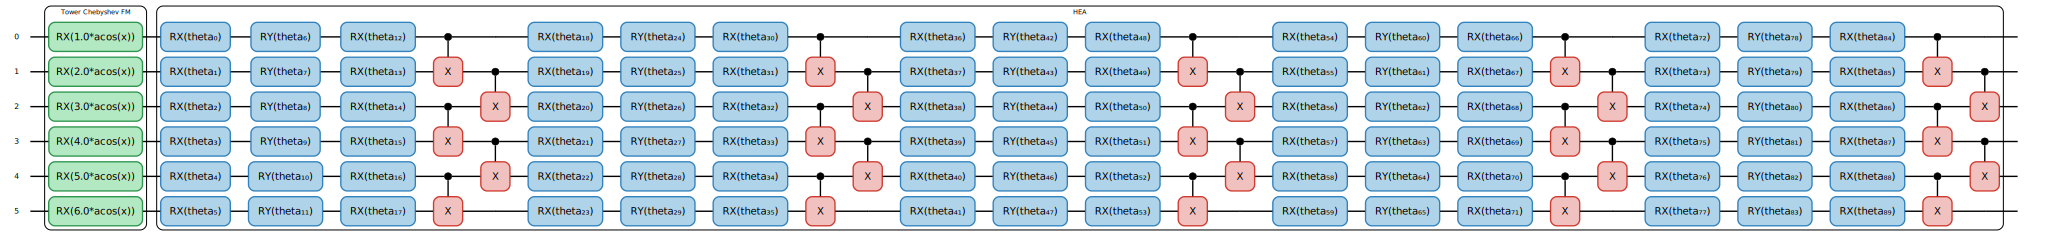

In [47]:
display(circuit)

In [48]:
n_epochs = 800
n_points = 20

xmin = 0
xmax = 0.90

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr = max(1/(epoch+1),0.01))
    optimizer.zero_grad()

    x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)

    loss = loss_fn(inputs = x_train, model = model)
    loss.backward()
    optimizer.step()

In [49]:
import matplotlib.pyplot as plt

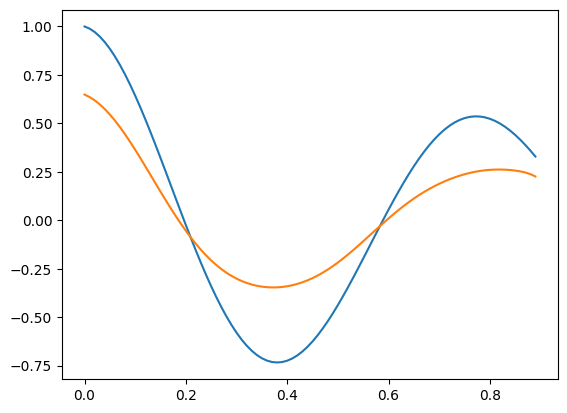

In [50]:
def f_exact(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(-0.8 * x) * torch.cos(8 * x)

x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution")
plt.plot(x_test, result_model, label = " Trained model")